### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit
import re
from sympy import symbols, simplify, sin, cos, log, Abs, exp, expand_power_base, Mul, Rational, sqrt
from sympy.parsing.sympy_parser import parse_expr
import seaborn as sns
import copy
import json
from ydata_profiling import ProfileReport

### extract expression from PySR results

In [2]:
pysr_results = pd.read_csv('C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/outputs/20250218_194332_fS3v29/hall_of_fame.csv')
num_independent_vars = 6

def generate_var_string(num_independent_vars):
    var_string = ''
    for i in range(num_independent_vars):
        var_string = var_string + ('x' + str(i) + ' ')
    return var_string[0:len(var_string) - 1]


def get_expression(expressions_df, num_vars):
    lowest_loss = float('inf')
    best_expression = None
    for _, row in expressions_df.iterrows():
        if row['Loss'] < lowest_loss and len(re.findall(r'x\d+', row['Equation'])) == num_vars:
            lowest_loss = row['Loss']
            best_expression = row['Equation']
    return best_expression

expr_str = get_expression(pysr_results, num_independent_vars)
variables = generate_var_string(num_independent_vars)
print(expr_str)
print(variables)

(x2 + sqrt(sqrt((x4 * abs((x5 - (x0 * sqrt(x5))) * x3)) + 4663.2124))) / 1.5260926
x0 x1 x2 x3 x4 x5


### prepare expression for .json conversion

In [3]:
# Define a function to recursively convert the expression tree
def expression_to_json(expr):
    # Base case: If the expression is a symbol (variable)
    if expr.is_Symbol:
        return f"$self.{expr}"

    # Base case: If the expression is a number (constant)
    if expr.is_Number:
        return str(expr)

    # If the expression is an addition
    if expr.is_Add:
        args = list(expr.args)
        arg_num = 1
        result = {}
        for arg in args:
            result[f'term{arg_num}'] = expression_to_json(arg)
            arg_num += 1
        result['type'] = 'ADDITIONDOUBLE'
        return result

    # If the expression is a multiplication
    if expr.is_Mul:
        args = list(expr.args)
        arg_num = 1
        result = {}
        for arg in args:
            result[f'term{arg_num}'] = expression_to_json(arg)
            arg_num += 1
        result['type'] = 'MULTIPLICATIONDOUBLE'
        return result

    # If the expression is a power
    if expr.is_Pow:
        if expr.exp == Rational(1, 2):
            args = list(expr.args)
            return {
                "term1": expression_to_json(args[0]),
                "type": "SQUAREROOT"
            }
        else:
            base, exponent = expr.as_base_exp()
            return {
                "term1": expression_to_json(base),
                "term2": expression_to_json(exponent),
                "type": "POWER"
            }
    
    if isinstance(expr, sin):
        args = list(expr.args)
        return {
                "term1": expression_to_json(args[0]),
                "type": "SINE"
            }
        
    if isinstance(expr, cos):
        args = list(expr.args)
        return {
                "term1": expression_to_json(args[0]),
                "type": "COSINE"
            }
    
    if isinstance(expr, exp):
        args = list(expr.args)
        return {
                "term1": expression_to_json(args[0]),
                "type": "EXPONENT"
            }
    
    if isinstance(expr, log):
        args = list(expr.args)
        return {
                "term1": expression_to_json(args[0]),
                "type": "LOGARITHM"
            }
    
    if isinstance(expr, Abs):
        args = list(expr.args)
        return {
                "term1": expression_to_json(args[0]),
                "type": "ABSOLUTEVALUE"
            }
    
    # If none of the above cases apply, return the string representation
    return str(expr)

exec(f"{', '.join(variables.split())} = symbols('{variables}')")

parsed_expr = parse_expr("0.655268232084999*x2 + 5.41489965267869*(0.000214444446064691*x4*Abs(x3*(x0*sqrt(x5) - x5)) + 1)**(1/4)")  # parse_expr(expr_str)
expr = simplify(parsed_expr)
print(expr)

# Convert the expression to JSON-like format
json_representation = expression_to_json(expr)

# Print the result as a JSON string
print(json.dumps(json_representation, indent=4))


0.655268232084999*x2 + 5.41489965267869*(0.000214444446064691*x4*Abs(x3*(x0*sqrt(x5) - x5)) + 1)**(1/4)
{
    "term1": {
        "term1": "0.655268232084999",
        "term2": "$self.x2",
        "type": "MULTIPLICATIONDOUBLE"
    },
    "term2": {
        "term1": "5.41489965267869",
        "term2": {
            "term1": {
                "term1": "1",
                "term2": {
                    "term1": "0.000214444446064691",
                    "term2": "$self.x4",
                    "term3": {
                        "term1": {
                            "term1": "$self.x3",
                            "term2": {
                                "term1": {
                                    "term1": "-1",
                                    "term2": "$self.x5",
                                    "type": "MULTIPLICATIONDOUBLE"
                                },
                                "term2": {
                                    "term1": "$self.x0",
              

### prepare profile for numeric columns

In [5]:
# import data
df = pd.read_csv('../data/credit_score/cleaned_credit_score.csv')

In [ ]:
# Dictionary to store results for each numeric column
fitted_results = {}

# Get a list of numeric columns in your DataFrame
numeric_cols = df.select_dtypes(include='number').columns

# remove target var from symbolic regression
numeric_cols = numeric_cols.drop('Interest_Rate')

# Define the subset of distributions to test.
# (You can change this list as needed.)
desired_dists = ['norm', 'lognorm', 'gamma']

for col in numeric_cols:
    print(f"Processing column: {col}")
    
    # Extract and clean the data for the current column
    data = df[col].dropna().values
    
    # Initialize a distfit object, restricting to only the desired distributions.
    # Setting verbose=0 will suppress the printed log.
    dfit = distfit(distr=desired_dists, verbose=0)
    
    # Fit the distributions on the data.
    dfit.fit_transform(data)
    
    # Retrieve the summary DataFrame that contains the fit results.
    summary_df = dfit.summary
    
    if not summary_df.empty:
        # Choose the best fit as the one with the lowest RSS (score)
        best_dist = summary_df['score'].idxmin()
        best_params = summary_df.loc[best_dist].to_dict()
        
        # Store the result for this column
        fitted_results[col] = {
            'best_distribution': best_dist,
            'parameters': best_params
        }
    else:
        fitted_results[col] = None

# Print the summarized fitted distributions per numeric column
# print("\nFitted distributions per numeric column:")
# for col, result in fitted_results.items():
#     print(f"\nColumn: {col}")
#     if result is not None:
#         # print("  Best Distribution:", result['best_distribution'])
#         print("  Parameters:")
#         for param, value in result['parameters'].items():
#             print(f"    {param}: {value}")
#     else:
#         print("  No fit available.")

Processing column: Age
Processing column: Annual_Income
Processing column: Monthly_Inhand_Salary
Processing column: Num_Bank_Accounts
Processing column: Num_Credit_Card
Processing column: Num_of_Loan
Processing column: Delay_from_due_date
Processing column: Num_of_Delayed_Payment
Processing column: Num_Credit_Inquiries
Processing column: Outstanding_Debt
Processing column: Credit_Utilization_Ratio
Processing column: Credit_History_Age
Processing column: Total_EMI_per_month
Processing column: Amount_invested_monthly
Processing column: Monthly_Balance


### get profile for numeric cols

In [22]:
def distributions_to_profile(distr_report):

    distr_profiles = []

    for col, result in distr_report.items():

        distr_elem = {
            'name': str(col),
            'type': 'num'
        }

        if result is not None:

            col_details = copy.deepcopy(result['parameters'])

            if col_details['name'] == 'norm':
                distr_details = {
                    'type': 'GAUSSIAN',
                    'mean': col_details['params'][0],
                    'deviation': col_details['params'][1]
                }
                distr_elem['wf.hr'] = distr_details
            elif col_details['name'] == 'lognorm':
                distr_details = {
                    'type': 'LOGNORM',
                    'mean': np.log(col_details['params'][2]),
                    'deviation': col_details['params'][0] 
                }
                distr_elem['wf.hr'] = distr_details
            elif col_details['name'] == 'gamma':
                distr_details = {
                    'type': 'GAMMA',
                    'alpha': col_details['params'][0],
                    'theta': col_details['params'][2] 
                }
                distr_elem['wf.hr'] = distr_details
            else:
                distr_elem['wf.hr'] = 'ERROR'
        else:
            distr_elem['message'] = 'ERROR'

        distr_profiles.append(distr_elem)
    
    return distr_profiles

gen_profile = distributions_to_profile(fitted_results)

print(json.dumps(gen_profile, indent=4))

[
    {
        "name": "Age",
        "type": "num",
        "wf.hr": {
            "type": "GAUSSIAN",
            "mean": 33.834306945577936,
            "deviation": 10.355353102328907
        }
    },
    {
        "name": "Annual_Income",
        "type": "num",
        "wf.hr": {
            "type": "LOGNORM",
            "mean": 10.329511230187531,
            "deviation": 1.139821448532692
        }
    },
    {
        "name": "Monthly_Inhand_Salary",
        "type": "num",
        "wf.hr": {
            "type": "LOGNORM",
            "mean": 8.066963536063083,
            "deviation": 0.7180729159754938
        }
    },
    {
        "name": "Num_Bank_Accounts",
        "type": "num",
        "wf.hr": {
            "type": "GAUSSIAN",
            "mean": 5.382157123834887,
            "deviation": 2.6042537725489514
        }
    },
    {
        "name": "Num_Credit_Card",
        "type": "num",
        "wf.hr": {
            "type": "LOGNORM",
            "mean": 2.256023732

### SR check against data

In [6]:
# define variables to use in expression
x0_ = df['Credit_History_Age'].to_numpy()
x1_ = df['Delay_from_due_date'].to_numpy()
x2_ = df['Num_Bank_Accounts'].to_numpy()
x3_ = df['Num_Credit_Inquiries'].to_numpy()
x4_ = df['Num_of_Delayed_Payment'].to_numpy()
x5_ = df['Outstanding_Debt'].to_numpy()

interest_rate_predicted = 0.655268232084999*x2_ + 5.41489965267869*(0.000214444446064691*x4_*np.abs(x3_*(x0_*np.sqrt(x5_) - x5_)) + 1)**(1/4)

### check residuals

5892


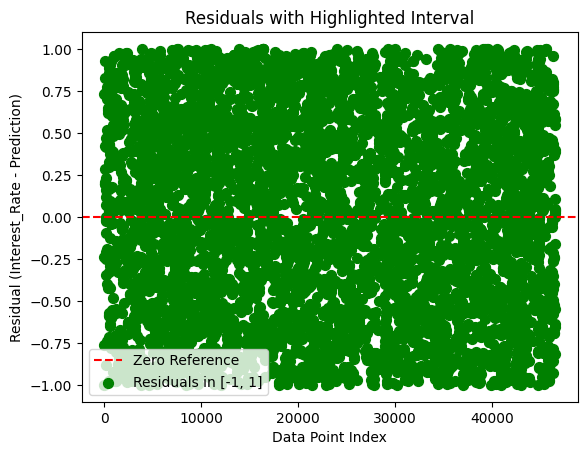

In [7]:
# Compute the residuals
residuals = df['Interest_Rate'] - interest_rate_predicted
residuals = residuals.reset_index(drop=True)

# Define your interval
lower_bound = -1
upper_bound = 1

# Create a mask for points within the interval
mask = (residuals >= lower_bound) & (residuals <= upper_bound)
print(len(mask[mask == True]))

# Plot the line plot for residuals
# plt.figure(figsize=(10, 5))
# plt.plot(residuals.index, residuals, label="Residuals", color="blue")

# Plot a horizontal reference line at 0
plt.axhline(0, color="red", linestyle="--", label="Zero Reference")

# Overlay scatter for the highlighted points
plt.scatter(residuals.index[mask], residuals[mask],
            color="green", s=50, label=f"Residuals in [{lower_bound}, {upper_bound}]")

plt.xlabel("Data Point Index")
plt.ylabel("Residual (Interest_Rate - Prediction)")
plt.title("Residuals with Highlighted Interval")
plt.legend()

### compare PySR results with actual values

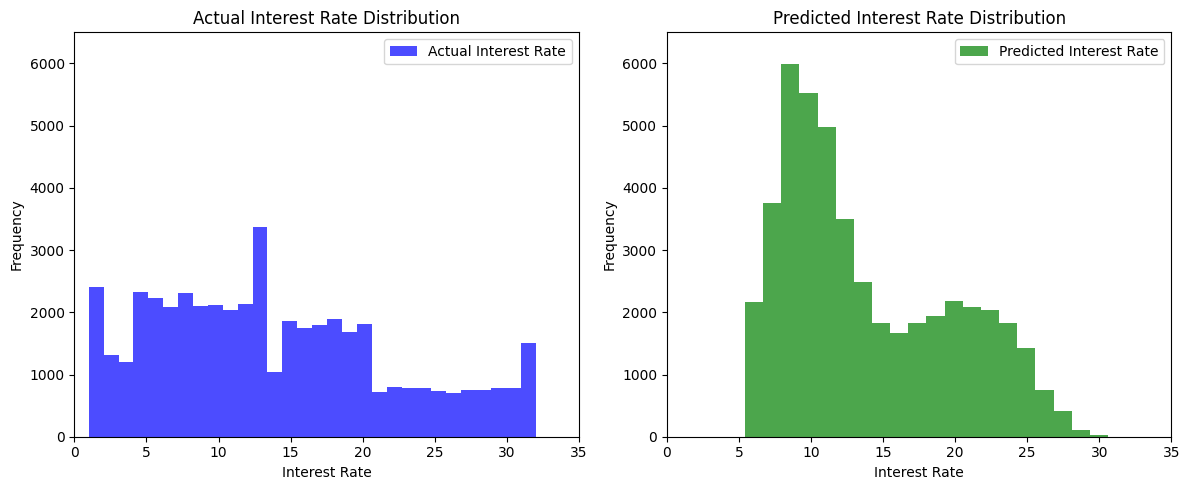

In [28]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 2, 1)
plt.hist(df['Interest_Rate'], bins=30, alpha=0.7, color='blue', label='Actual Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Actual Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 2, 2)
plt.hist(interest_rate_predicted, bins=30, alpha=0.7, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

plt.tight_layout()
plt.show()

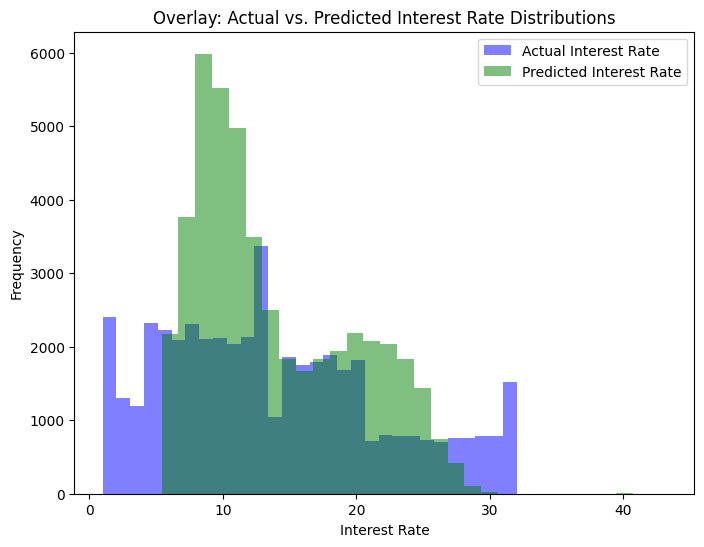

In [11]:
# overlay of histograms
plt.figure(figsize=(8, 6))
plt.hist(df['Interest_Rate'], bins=30, alpha=0.5, color='blue', label='Actual Interest Rate')
plt.hist(interest_rate_predicted, bins=30, alpha=0.5, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Overlay: Actual vs. Predicted Interest Rate Distributions')
plt.legend()
plt.show()

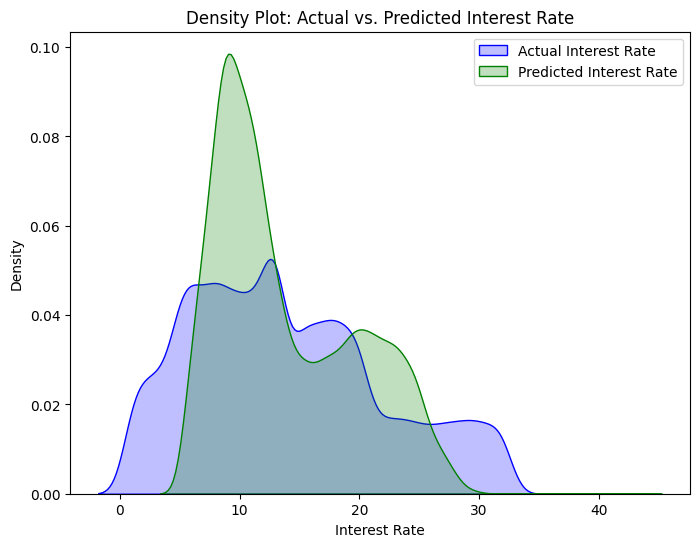

In [12]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['Interest_Rate'], fill=True, color='blue', label='Actual Interest Rate')
sns.kdeplot(interest_rate_predicted, fill=True, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Predicted Interest Rate')
plt.legend()
plt.show()

### export y-data profiling report

In [14]:
# prepare data frame for synthetic data
df = df.reset_index(drop=True)
interest_rate_predicted = pd.Series(interest_rate_predicted)
df_syn = df.copy()
df_syn['Interest_Rate'] = interest_rate_predicted

# Generate the profiling report
##profile_sample_syn = ProfileReport(df_syn, title="YData Profiling Report CREDIT CLEANED SYN", explorative=True)

# Step 5: Display the report in the notebook
##profile_sample_syn.to_notebook_iframe()

# Alternatively, save the report to an HTML file
##profile_sample_syn.to_file('../profiling/profiling_report__cleaned_credit_score_SYN.html')

In [38]:
df_syn.to_csv('credit_score_syn_interest_rate.csv')

## Test Residual NN

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assume these are your pandas Series and DataFrame:
# interest_rate_predicted: SR prediction (Series)
# residuals: computed residuals = actual - SR prediction (Series)
# df: DataFrame that includes the original features and the 'Interest_Rate' column

# For this example, select some original features:
features_df = df[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts',
                  'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']]

# Combine SR prediction as an additional feature
X = pd.concat([features_df, interest_rate_predicted.rename("SR_pred")], axis=1)
y = residuals  # target: residuals computed from (actual - SR prediction)

# Split data for training and testing (if desired)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 5000
model_xgb = xgb.train(params, dtrain, num_rounds)

# Evaluate on test set
y_pred_test = model_xgb.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"XGBoost Residual Correction Test MSE: {mse_test:.4f}")

# For final predictions, use the full dataset:
dall = xgb.DMatrix(X)
predicted_residual_correction = model_xgb.predict(dall)

# Compute final prediction as the sum of the SR prediction and the predicted residual correction
final_prediction = interest_rate_predicted + predicted_residual_correction

# Optionally, compute overall MSE against actual values
final_mse = mean_squared_error(df['Interest_Rate'], final_prediction)
print(f"Final MSE after XGBoost residual correction: {final_mse:.4f}")

XGBoost Residual Correction Test MSE: 12.8925
Final MSE after XGBoost residual correction: 3.2508


In [16]:
print(final_prediction)

0         3.797578
1         5.777703
2         3.079957
3         3.440653
4         7.167620
           ...    
46557    28.084345
46558     9.811693
46559     7.106850
46560     7.186980
46561     7.522976
Length: 46562, dtype: float64


In [17]:
print(df['Interest_Rate'])

0         3
1         3
2         3
3         3
4         6
         ..
46557    29
46558     7
46559     7
46560     7
46561     7
Name: Interest_Rate, Length: 46562, dtype: int64


179


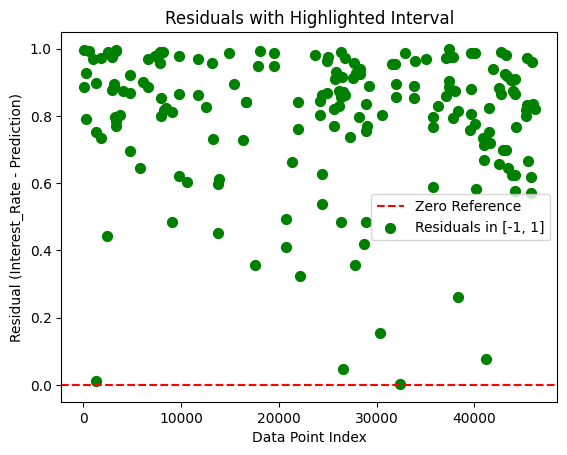

In [18]:
# Define your interval
lower_bound = -1
upper_bound = 1

# Create a mask for points within the interval
mask = (final_prediction >= lower_bound) & (final_prediction <= upper_bound)
print(len(mask[mask == True]))

# Plot the line plot for final_prediction_series
# plt.figure(figsize=(10, 5))
# plt.plot(final_prediction_series.index, final_prediction_series, label="Residuals", color="blue")

# Plot a horizontal reference line at 0
plt.axhline(0, color="red", linestyle="--", label="Zero Reference")

# Overlay scatter for the highlighted points
plt.scatter(final_prediction.index[mask], final_prediction[mask],
            color="green", s=50, label=f"Residuals in [{lower_bound}, {upper_bound}]")

plt.xlabel("Data Point Index")
plt.ylabel("Residual (Interest_Rate - Prediction)")
plt.title("Residuals with Highlighted Interval")
plt.legend()

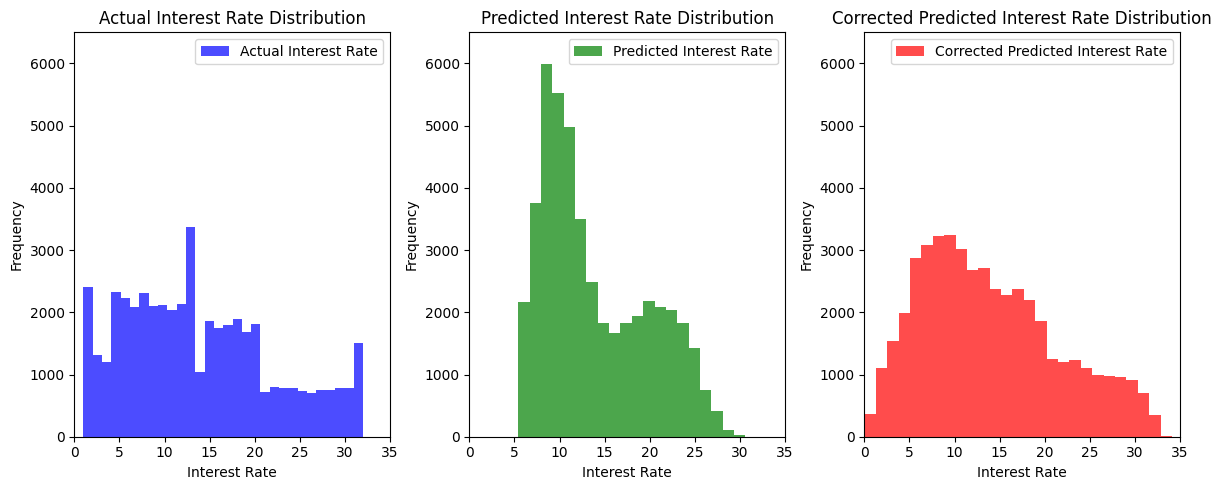

In [29]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 3, 1)
plt.hist(df['Interest_Rate'], bins=30, alpha=0.7, color='blue', label='Actual Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Actual Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 2)
plt.hist(interest_rate_predicted, bins=30, alpha=0.7, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Corrected Predicted Interest Rate distribution
plt.subplot(1, 3, 3)
plt.hist(final_prediction, bins=30, alpha=0.7, color='red', label='Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

plt.tight_layout()
plt.show()

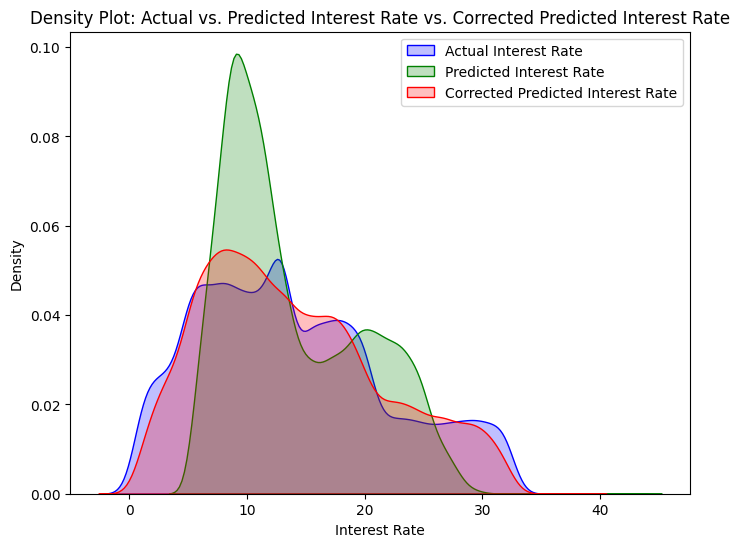

In [20]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['Interest_Rate'], fill=True, color='blue', label='Actual Interest Rate')
sns.kdeplot(interest_rate_predicted, fill=True, color='green', label='Predicted Interest Rate')
sns.kdeplot(final_prediction, fill=True, color='red', label='Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Predicted Interest Rate vs. Corrected Predicted Interest Rate')
plt.legend()
plt.show()

### Simulation of CONCEPT DRIFT

In [21]:
interest_rate_predicted_mod = 1.655268232084999*x2_ + 5.41489965267869*(0.000214444446064691*x4_*np.abs(x3_*(x0_*np.sqrt(x5_) - x5_)) + 1)**(1/4)

final_prediction_mod = interest_rate_predicted_mod + predicted_residual_correction

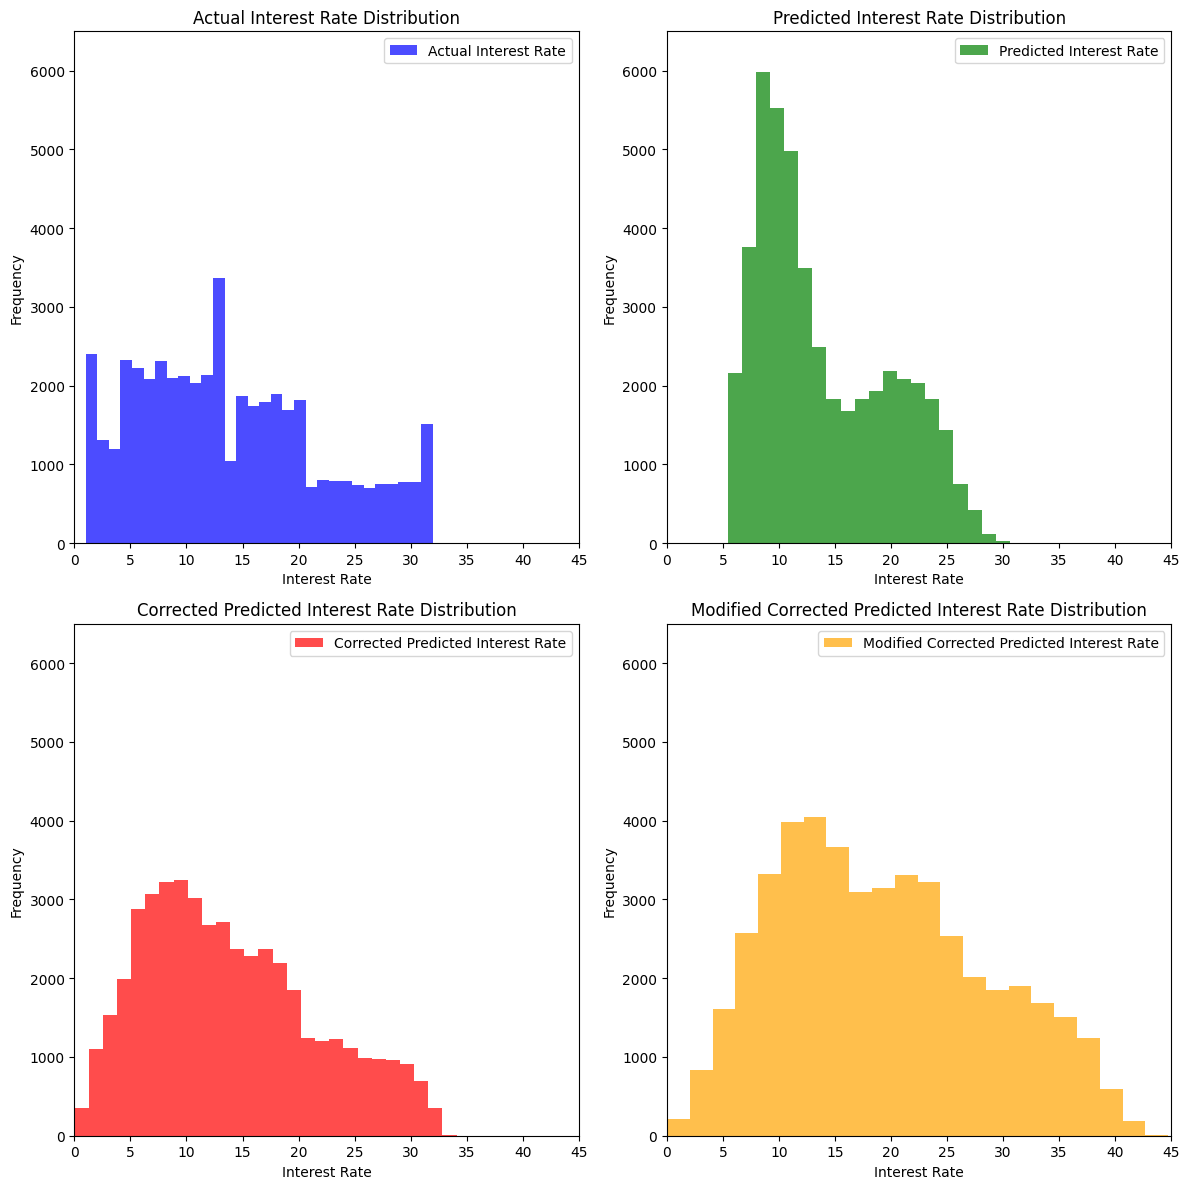

In [30]:
# Create a figure with two subplots
plt.figure(figsize=(12, 12))

# Plot the Actual Interest Rate distribution
plt.subplot(2, 2, 1)
plt.hist(df['Interest_Rate'], bins=30, alpha=0.7, color='blue', label='Actual Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Actual Interest Rate Distribution')
plt.legend()
plt.xlim(0, 45)
plt.ylim(0, 6500)

# Plot the Predicted Interest Rate distribution
plt.subplot(2, 2, 2)
plt.hist(interest_rate_predicted, bins=30, alpha=0.7, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 45)
plt.ylim(0, 6500)

# Plot the Corrected Predicted Interest Rate distribution
plt.subplot(2, 2, 3)
plt.hist(final_prediction, bins=30, alpha=0.7, color='red', label='Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 45)
plt.ylim(0, 6500)

# Plot the Corrected Predicted Interest Rate distribution
plt.subplot(2, 2, 4)
plt.hist(final_prediction_mod, bins=30, alpha=0.7, color='orange', label='Modified Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Modified Corrected Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 45)
plt.ylim(0, 6500)

plt.tight_layout()
plt.show()

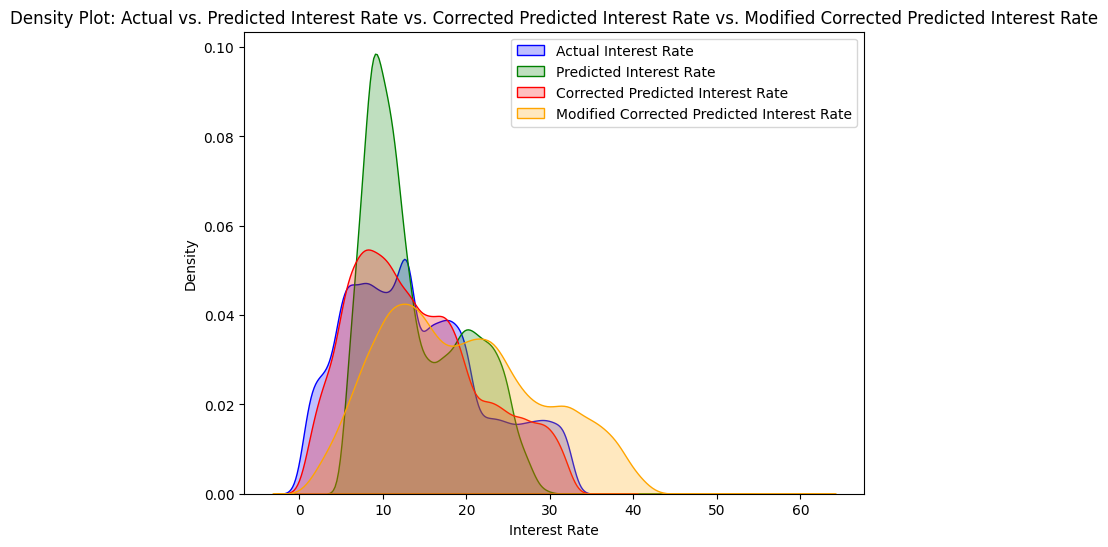

In [23]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['Interest_Rate'], fill=True, color='blue', label='Actual Interest Rate')
sns.kdeplot(interest_rate_predicted, fill=True, color='green', label='Predicted Interest Rate')
sns.kdeplot(final_prediction, fill=True, color='red', label='Corrected Predicted Interest Rate')
sns.kdeplot(final_prediction_mod, fill=True, color='orange', label='Modified Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Predicted Interest Rate vs. Corrected Predicted Interest Rate vs. Modified Corrected Predicted Interest Rate')
plt.legend()
plt.show()

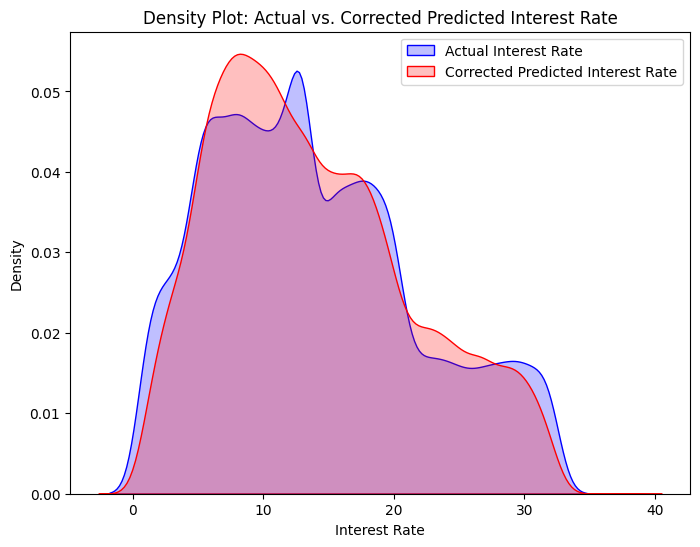

In [31]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['Interest_Rate'], fill=True, color='blue', label='Actual Interest Rate')
sns.kdeplot(final_prediction, fill=True, color='red', label='Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Corrected Predicted Interest Rate')
plt.legend()
plt.show()

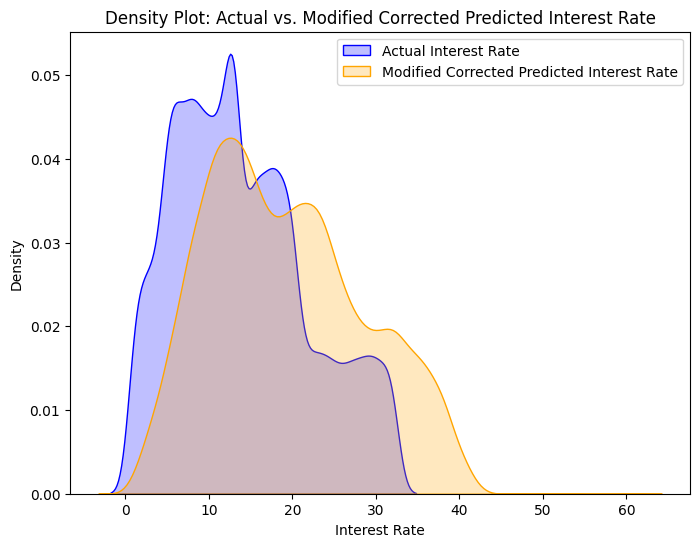

In [32]:
# density plots

plt.figure(figsize=(8, 6))
sns.kdeplot(df['Interest_Rate'], fill=True, color='blue', label='Actual Interest Rate')
sns.kdeplot(final_prediction_mod, fill=True, color='orange', label='Modified Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs. Modified Corrected Predicted Interest Rate')
plt.legend()
plt.show()